In [25]:
from datasets import load_dataset
import random
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tokenizers import Tokenizer, models, trainers
from tokenizers.pre_tokenizers import Whitespace
import torch.nn as nn
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [26]:
emotions = load_dataset("dair-ai/emotion")

In [27]:
labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

In [28]:
train_data = emotions["train"]
validation_data = emotions["validation"]
test_data = emotions["test"]

In [29]:
train_preprocess = np.array(train_data["text"]).reshape(-1,1)
train_preprocess

array([['i didnt feel humiliated'],
       ['i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'],
       ['im grabbing a minute to post i feel greedy wrong'],
       ...,
       ['i feel strong and good overall'],
       ['i feel like this was such a rude comment and im glad that t'],
       ['i know a lot but i feel so stupid because i can not portray it']],
      shape=(16000, 1), dtype='<U300')

In [30]:
oversample = RandomOverSampler()
train_text_oversample, train_data_oversample = oversample.fit_resample(train_preprocess, train_data["label"])
len(train_text_oversample)

32172

In [31]:
from collections import Counter

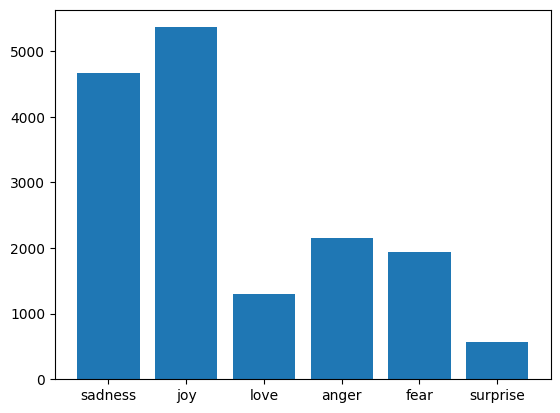

In [32]:
label_count = Counter(train_data["label"])
label_list = dict(sorted(label_count.items())).values()
fig, ax = plt.subplots()
ax.bar(labels, label_list)
plt.show()

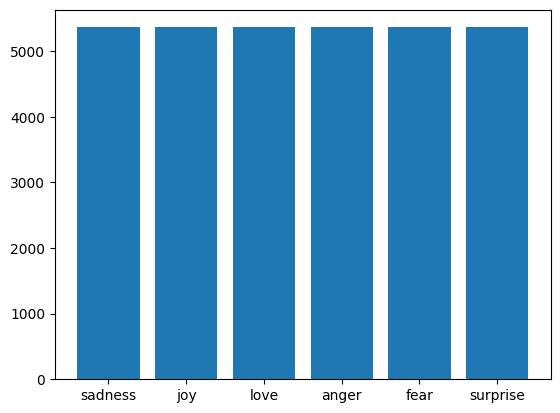

In [33]:
label_count = Counter(train_data_oversample)
label_list = dict(sorted(label_count.items())).values()
fig, ax = plt.subplots()
ax.bar(labels, label_list)
plt.show()

In [34]:
# Tokenization
vocab_n = 5000
sequence_len = 64

# Initialize a tokenizer using BPE (Byte Pair Encoding)
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_padding(length=sequence_len)
tokenizer.enable_truncation(max_length=sequence_len)
tokenizer_trainer = trainers.BpeTrainer(vocab_size=vocab_n)
tokenizer.train_from_iterator(train_data["text"], trainer=tokenizer_trainer)

In [35]:
def preprocess_text(text: str, tokenizer: Tokenizer):
    """ 
    Helper function to tokenize text and return corresponding token IDs as tensors.

    Args:
        text, str: Text instance from training data.
        tokenizer, Tokenizer: The respective tokenizer to be used for tokenization.
    Returns:
        Tensor: One-dimensional PyTorch tensor with token IDs.
    """
    return torch.tensor(tokenizer.encode(text).ids)


def preprocess_label(label: int):
    """ 
    Helper function to return label as tensor.

    Args:
        label, int: Label from instance.
    Returns:
        Tensor: One-dimensional PyTorch tensor containing the label index.
    """
    return torch.tensor(label)


def preprocess(data: dict, tokenizer: Tokenizer):
    """ 
    Transforms input dataset to tokenized vector representations.

    Args:
        data, dict: Dictionary with text instances and labels.
        tokenizer, Tokenizer: The respective tokenizer to be used for tokenization.
    Returns:
        list: List with tensors for the input texts and labels.
    """
    instances = []

    for text, label in zip(data["text"], data["label"]):
        input = preprocess_text(text, tokenizer)
        label = preprocess_label(label)
        
        instances.append((input, label))

    return instances

In [36]:
train_instances = preprocess(train_data, tokenizer)
val_instances = preprocess(validation_data, tokenizer)
test_instances = preprocess(test_data, tokenizer)

In [37]:
# Batching

def batching(instances: list, batch_size: int, shuffle: bool):
    """ 
    Batches input instances along the given size and returns list of batches.

    Args:
        instances, list: List of instances, containing a tuple of two tensors 
            for each text as well as corresponding label.
        batch_size, int: Size for batches.
        shuffle, bool: If true, the instances will be shuffled before batching.
    Returns:
        list: List containing tuples that correspond to single batches.
    """
    if shuffle:
        random.shuffle(instances)

    batches = []

    # We iterate through the instances with batch_size steps
    for i in range(0, len(instances), batch_size):

        # Stacking the instances with dim=0 (default value)
        batch_texts = torch.stack(
            [instance[0] for instance in instances[i : i + batch_size]]
        )
        batch_labels = torch.stack(
            [instance[1] for instance in instances[i : i + batch_size]]
        )

        batches.append((batch_texts, batch_labels))
    
    return batches

In [38]:

train_losses = []
val_losses = []


In [39]:
# CNN Network

class CNN_Classifier(nn.Module):
    """ 
    CNN for sentiment classification with 6 classes, consisting of an embedding 
    layer, two convolutional layers with different filter sizes, different 
    pooling sizes, as well as one linear output layer.
    """
    def __init__(self):
        super().__init__()
        # We can implement embeddings as a simple lookup-table for given word 
        # indices
        self.embedding = nn.Embedding(tokenizer.get_vocab_size(), 300)

        # One-dimensional convolution-layer with 300 input channels, and 100  
        # output channels as well as kernel size of 3; note that the
        # one-dimensional convolutional layer has 3 dimensions
        self.conv_1 = nn.Conv1d(300, 100, 3, padding="same")

        # Pooling with with a one-dimensional sliding window of length 3, 
        # reducing in this fashion the sequence length 
        self.pool_1 = nn.MaxPool1d(3)

        # The input will be the reduced number of maximum picks from the
        # previous operation; the dimension of those picks is the same as the
        # output channel size from self.conv_1. We apply a different filter of 
        # size 5.
        self.conv_2 = nn.Conv1d(100, 50, 5, padding="same")

        # Pooling with window size of 5
        self.pool_2 = nn.MaxPool1d(5)

        # Final fully connected linear layer from the 50 output channels to the
        # 6 sentiment categories 
        self.linear_layer = nn.Linear(50, 6)

    def forward(self, x):
        """ 
        Defining the forward pass of an input batch x.

        Args:
            x, tensor: The input is a batch of tweets from the data.
        Returns:
            y, float: The output are the logits from the final layer.
        """
        # x will correspond here to a batch; therefore, the input dimensions of 
        # the embedding will be by PyTorch convention as follows:
        # [batch_size, seq_len, emb_dim]
        x = self.embedding(x)

        # Unfortunately the embedding tensor does not correspond to the shape 
        # that is needed for nn.Conv1d(); for this reason, we must switch its 
        # order to [batch_size, emb_dim, seq_len] for PyTorch
        x = x.permute(0, 2, 1)

        # We can wrap the ReLu activation function around our convolution layer
        # The output tensor will have the following shape: 
        # [batch_size, 100, seq_len]
        x = nn.functional.relu(self.conv_1(x))

        # Applying max pooling of size 3 means that the output length of the 
        # sequence is shrunk to seq_len//3
        x = self.pool_1(x)

        # Output of the following layer: [batch_size, 50, seq_len//3]
        x = nn.functional.relu(self.conv_2(x))

        # Shrinking the sequence length by 5
        x = self.pool_2(x)
        # print(x.shape)

        # At this point we have a tensor with 3 dimensions; however, the final layer 
        # requires an input of size [batch_size x 50]. To get this value we can 
        # aggregate the values and continue only with their mean
        x = x.mean(dim=-1)

        # In this fasion, the linear layer can be used to make predictions
        y = self.linear_layer(x)

        return y
    
    
    def fit(self, train_instances, val_instances, epochs, batch_size):
        """ 
        Gradient based fitting method with Adam optimization and automatic 
        evaluation (F1 score) for each epoch.

        Args:
            train_instances, list: List of instance tuples.
            val_instances, list: List of instance tuples.
            epochs, int: Number of training epochs.
            batch_size, int: Number of batch size.
        """
        
        self.train()
        optimizer = torch.optim.Adam(self.parameters())

        self.val_score = []
        self.train_losses = []
        self.val_losses = []

        for epoch in range(epochs):
            train_batches = batching(train_instances, batch_size=batch_size, shuffle=True)
            epoch_train_loss = 0.0
            total_train_samples = 0

            for inputs, labels in tqdm(train_batches):
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = nn.functional.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item() * inputs.size(0)
                total_train_samples += inputs.size(0)

            avg_train_loss = epoch_train_loss / total_train_samples
            self.train_losses.append(avg_train_loss)

            # Evaluate on validation set
            self.eval()
            val_batches = batching(val_instances, batch_size=batch_size, shuffle=False)
            epoch_val_loss = 0.0
            total_val_samples = 0

            with torch.no_grad():
                for inputs, labels in val_batches:
                    outputs = self(inputs)
                    loss = nn.functional.cross_entropy(outputs, labels)
                    epoch_val_loss += loss.item() * inputs.size(0)
                    total_val_samples += inputs.size(0)

            avg_val_loss = epoch_val_loss / total_val_samples
            self.val_losses.append(avg_val_loss)

            train_f1 = self.evaluate2(train_instances, batch_size=batch_size)
            val_f1 = self.evaluate2(val_instances, batch_size=batch_size)
            self.val_score.append(val_f1)

            print(f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
                  f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

    def predict(self, input):
        """ 
        To make inferences from the model.

        Args:
            input, tensor: Single instance.
        Returns:
            int: Integer for most probable class.
        """
        self.eval()
        outputs = self(input)

        return torch.argmax(outputs, dim=-1)

    def evaluate(self, instances, batch_size):
        """ 
        To evaluate model's performance by various processes/standard.

        Args:
            instances, list: List of instance tuples.
            batch_size, int: Batch size.
        Returns:
            float: Macro F1 score for given instances.
        """
        batches = batching(instances, batch_size=batch_size, shuffle=False)
        y_test = []
        y_pred = []

        for inputs, labels in batches:
            y_test.extend(labels)
            y_pred.extend(self.predict(inputs))

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        print("CNN Classifier:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{report}")
    
    def evaluate2(self, instances, batch_size):
        """ 
        To make evaluations against the gold standard (true labels) from the 
        data.

        Args:
            instances, list: List of instance tuples.
            batch_size, int: Batch size.
        Returns:
            float: Macro F1 score for given instances.
        """
        batches = batching(instances, batch_size=batch_size, shuffle=False)
        true = []
        pred = []

        for inputs, labels in batches:
            true.extend(labels)
            pred.extend(self.predict(inputs))

        return f1_score(true, pred, average="macro")

In [ ]:
classifier = CNN_Classifier()
classifier.fit(train_instances, val_instances, epochs=5, batch_size=16)

100%|██████████| 1000/1000 [00:03<00:00, 251.73it/s]


Epoch 1 | Train Loss: 1.2715 | Val Loss: 0.8098 | Train F1: 0.5986 | Val F1: 0.5291


100%|██████████| 1000/1000 [00:03<00:00, 266.08it/s]


Epoch 2 | Train Loss: 0.4015 | Val Loss: 0.3435 | Train F1: 0.9208 | Val F1: 0.8292


100%|██████████| 1000/1000 [00:03<00:00, 266.61it/s]


Epoch 3 | Train Loss: 0.1566 | Val Loss: 0.3405 | Train F1: 0.9596 | Val F1: 0.8425


100%|██████████| 1000/1000 [00:03<00:00, 255.09it/s]


Epoch 4 | Train Loss: 0.0775 | Val Loss: 0.3143 | Train F1: 0.9824 | Val F1: 0.8625


100%|██████████| 1000/1000 [00:03<00:00, 261.69it/s]


Epoch 5 | Train Loss: 0.0518 | Val Loss: 0.4132 | Train F1: 0.9852 | Val F1: 0.8551


100%|██████████| 1000/1000 [00:03<00:00, 259.74it/s]


Epoch 6 | Train Loss: 0.0447 | Val Loss: 0.4641 | Train F1: 0.9845 | Val F1: 0.8590


100%|██████████| 1000/1000 [00:03<00:00, 258.39it/s]


Epoch 7 | Train Loss: 0.0434 | Val Loss: 0.4468 | Train F1: 0.9912 | Val F1: 0.8634


100%|██████████| 1000/1000 [00:03<00:00, 250.38it/s]


Epoch 8 | Train Loss: 0.0339 | Val Loss: 0.4793 | Train F1: 0.9897 | Val F1: 0.8713


100%|██████████| 1000/1000 [00:03<00:00, 258.37it/s]


Epoch 9 | Train Loss: 0.0289 | Val Loss: 0.4918 | Train F1: 0.9931 | Val F1: 0.8659


100%|██████████| 1000/1000 [00:03<00:00, 255.47it/s]


Epoch 10 | Train Loss: 0.0310 | Val Loss: 0.5064 | Train F1: 0.9930 | Val F1: 0.8664


100%|██████████| 1000/1000 [00:03<00:00, 252.87it/s]


Epoch 11 | Train Loss: 0.0252 | Val Loss: 0.5331 | Train F1: 0.9859 | Val F1: 0.8518


100%|██████████| 1000/1000 [00:04<00:00, 247.67it/s]


Epoch 12 | Train Loss: 0.0230 | Val Loss: 0.4840 | Train F1: 0.9915 | Val F1: 0.8670


100%|██████████| 1000/1000 [00:03<00:00, 256.99it/s]


Epoch 13 | Train Loss: 0.0207 | Val Loss: 0.5303 | Train F1: 0.9910 | Val F1: 0.8703


100%|██████████| 1000/1000 [00:03<00:00, 253.78it/s]


Epoch 14 | Train Loss: 0.0216 | Val Loss: 0.5073 | Train F1: 0.9952 | Val F1: 0.8738


100%|██████████| 1000/1000 [00:03<00:00, 258.41it/s]


Epoch 15 | Train Loss: 0.0191 | Val Loss: 0.7161 | Train F1: 0.9887 | Val F1: 0.8533


100%|██████████| 1000/1000 [00:03<00:00, 255.25it/s]


Epoch 16 | Train Loss: 0.0195 | Val Loss: 0.5309 | Train F1: 0.9950 | Val F1: 0.8761


100%|██████████| 1000/1000 [00:04<00:00, 247.20it/s]


Epoch 17 | Train Loss: 0.0176 | Val Loss: 0.5495 | Train F1: 0.9955 | Val F1: 0.8774


100%|██████████| 1000/1000 [00:03<00:00, 256.59it/s]


Epoch 18 | Train Loss: 0.0180 | Val Loss: 0.6148 | Train F1: 0.9948 | Val F1: 0.8657


100%|██████████| 1000/1000 [00:03<00:00, 266.63it/s]


Epoch 19 | Train Loss: 0.0136 | Val Loss: 0.6465 | Train F1: 0.9961 | Val F1: 0.8807


100%|██████████| 1000/1000 [00:03<00:00, 263.51it/s]


Epoch 20 | Train Loss: 0.0118 | Val Loss: 0.5500 | Train F1: 0.9965 | Val F1: 0.8788


100%|██████████| 1000/1000 [00:03<00:00, 254.59it/s]


Epoch 21 | Train Loss: 0.0133 | Val Loss: 0.7603 | Train F1: 0.9856 | Val F1: 0.8576


100%|██████████| 1000/1000 [00:03<00:00, 257.34it/s]


Epoch 22 | Train Loss: 0.0139 | Val Loss: 0.6206 | Train F1: 0.9958 | Val F1: 0.8752


100%|██████████| 1000/1000 [00:03<00:00, 258.21it/s]


Epoch 23 | Train Loss: 0.0120 | Val Loss: 0.8348 | Train F1: 0.9876 | Val F1: 0.8487


100%|██████████| 1000/1000 [00:04<00:00, 249.92it/s]


Epoch 24 | Train Loss: 0.0172 | Val Loss: 0.7145 | Train F1: 0.9965 | Val F1: 0.8679


100%|██████████| 1000/1000 [00:03<00:00, 265.02it/s]


Epoch 25 | Train Loss: 0.0105 | Val Loss: 0.7284 | Train F1: 0.9953 | Val F1: 0.8686


100%|██████████| 1000/1000 [00:03<00:00, 257.35it/s]


Epoch 26 | Train Loss: 0.0087 | Val Loss: 0.6994 | Train F1: 0.9966 | Val F1: 0.8648


100%|██████████| 1000/1000 [00:03<00:00, 259.01it/s]


Epoch 27 | Train Loss: 0.0080 | Val Loss: 0.6908 | Train F1: 0.9967 | Val F1: 0.8717


100%|██████████| 1000/1000 [00:03<00:00, 255.82it/s]


Epoch 28 | Train Loss: 0.0135 | Val Loss: 0.7093 | Train F1: 0.9966 | Val F1: 0.8769


100%|██████████| 1000/1000 [00:03<00:00, 262.03it/s]


Epoch 29 | Train Loss: 0.0103 | Val Loss: 0.6608 | Train F1: 0.9957 | Val F1: 0.8693


100%|██████████| 1000/1000 [00:03<00:00, 264.90it/s]


Epoch 30 | Train Loss: 0.0117 | Val Loss: 0.7577 | Train F1: 0.9951 | Val F1: 0.8685


100%|██████████| 1000/1000 [00:03<00:00, 252.14it/s]


Epoch 31 | Train Loss: 0.0101 | Val Loss: 0.7981 | Train F1: 0.9955 | Val F1: 0.8651


100%|██████████| 1000/1000 [00:04<00:00, 246.11it/s]


Epoch 32 | Train Loss: 0.0061 | Val Loss: 0.6880 | Train F1: 0.9970 | Val F1: 0.8669


100%|██████████| 1000/1000 [00:03<00:00, 256.44it/s]


Epoch 33 | Train Loss: 0.0075 | Val Loss: 0.7955 | Train F1: 0.9962 | Val F1: 0.8712


100%|██████████| 1000/1000 [00:03<00:00, 258.44it/s]


Epoch 34 | Train Loss: 0.0101 | Val Loss: 0.7342 | Train F1: 0.9945 | Val F1: 0.8650


100%|██████████| 1000/1000 [00:03<00:00, 266.02it/s]


Epoch 35 | Train Loss: 0.0114 | Val Loss: 0.7212 | Train F1: 0.9964 | Val F1: 0.8691


100%|██████████| 1000/1000 [00:03<00:00, 253.98it/s]


Epoch 36 | Train Loss: 0.0090 | Val Loss: 0.7078 | Train F1: 0.9966 | Val F1: 0.8706


100%|██████████| 1000/1000 [00:03<00:00, 259.05it/s]


Epoch 37 | Train Loss: 0.0073 | Val Loss: 0.8143 | Train F1: 0.9968 | Val F1: 0.8657


100%|██████████| 1000/1000 [00:03<00:00, 256.74it/s]


Epoch 38 | Train Loss: 0.0082 | Val Loss: 0.8046 | Train F1: 0.9962 | Val F1: 0.8751


100%|██████████| 1000/1000 [00:03<00:00, 260.46it/s]


Epoch 39 | Train Loss: 0.0089 | Val Loss: 0.7942 | Train F1: 0.9968 | Val F1: 0.8709


100%|██████████| 1000/1000 [00:03<00:00, 257.02it/s]


Epoch 40 | Train Loss: 0.0083 | Val Loss: 0.7744 | Train F1: 0.9967 | Val F1: 0.8768


100%|██████████| 1000/1000 [00:03<00:00, 258.63it/s]


Epoch 41 | Train Loss: 0.0096 | Val Loss: 0.8285 | Train F1: 0.9963 | Val F1: 0.8716


100%|██████████| 1000/1000 [00:03<00:00, 260.66it/s]


Epoch 42 | Train Loss: 0.0106 | Val Loss: 0.8453 | Train F1: 0.9960 | Val F1: 0.8770


100%|██████████| 1000/1000 [00:03<00:00, 261.25it/s]


Epoch 43 | Train Loss: 0.0064 | Val Loss: 0.7257 | Train F1: 0.9968 | Val F1: 0.8728


100%|██████████| 1000/1000 [00:03<00:00, 261.78it/s]


Epoch 44 | Train Loss: 0.0049 | Val Loss: 0.7575 | Train F1: 0.9970 | Val F1: 0.8762


100%|██████████| 1000/1000 [00:03<00:00, 256.14it/s]


Epoch 45 | Train Loss: 0.0051 | Val Loss: 0.7770 | Train F1: 0.9970 | Val F1: 0.8732


100%|██████████| 1000/1000 [00:03<00:00, 259.98it/s]


Epoch 46 | Train Loss: 0.0045 | Val Loss: 0.8129 | Train F1: 0.9968 | Val F1: 0.8714


100%|██████████| 1000/1000 [00:03<00:00, 254.49it/s]


Epoch 47 | Train Loss: 0.0149 | Val Loss: 0.9777 | Train F1: 0.9956 | Val F1: 0.8730


100%|██████████| 1000/1000 [00:03<00:00, 262.04it/s]


Epoch 48 | Train Loss: 0.0093 | Val Loss: 0.8726 | Train F1: 0.9965 | Val F1: 0.8744


100%|██████████| 1000/1000 [00:03<00:00, 262.76it/s]


Epoch 49 | Train Loss: 0.0059 | Val Loss: 0.9327 | Train F1: 0.9965 | Val F1: 0.8732


100%|██████████| 1000/1000 [00:04<00:00, 249.77it/s]


Epoch 50 | Train Loss: 0.0062 | Val Loss: 0.9116 | Train F1: 0.9966 | Val F1: 0.8776


In [41]:
f1_test = classifier.evaluate(test_instances, batch_size=16)

CNN Classifier:
Accuracy: 0.895
Precision: 0.8535380418474876
Recall: 0.8353477098710022
F1 Score: 0.8436453544737357
Confusion Matrix:
[[551   8   1  13   7   1]
 [  5 640  38   5   2   5]
 [  3  34 118   3   0   1]
 [ 15   7   0 249   3   1]
 [ 11   5   0  13 189   6]
 [  3   7   0   2  11  43]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       581
           1       0.91      0.92      0.92       695
           2       0.75      0.74      0.75       159
           3       0.87      0.91      0.89       275
           4       0.89      0.84      0.87       224
           5       0.75      0.65      0.70        66

    accuracy                           0.90      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.89      0.90      0.89      2000



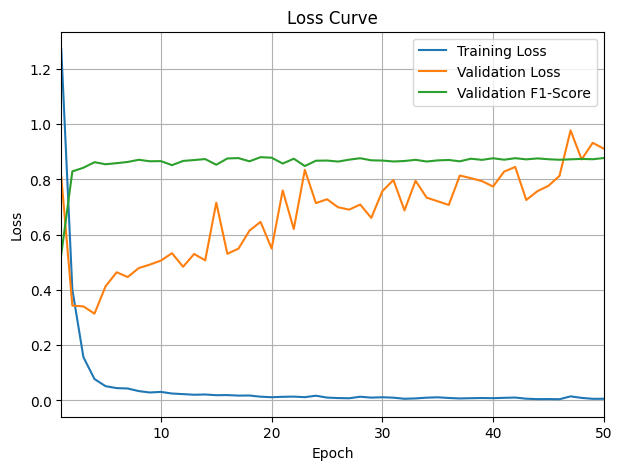

In [42]:
# === Plot Training and Validation Loss ===

plt.figure(figsize=(7, 5))
x_values = np.arange(1, len(classifier.train_losses) + 1)
plt.plot(x_values, classifier.train_losses, label='Training Loss')
plt.plot(x_values, classifier.val_losses, label='Validation Loss')
plt.plot(x_values, classifier.val_score, label='Validation F1-Score')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.xlim(1, 50)
plt.legend()
plt.grid(True)
plt.show()